<h1 style="text-align: center; font-weight: bold;">
Experiments Model LSTM 
</h1>


# LLibreries

In [11]:
# 📦 Gestió bàsica de dades i formats
import os
import json
import random
import warnings
from datetime import datetime
from itertools import combinations

# 📊 Tractament i visualització de dades
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import plotly.express as px

# Configuració visuals
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")  # Ignorar warnings per evitar soroll

# 📈 Barra de progrés
from tqdm.notebook import tqdm

# 🧪 Preprocessament i mètriques
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error)

# 🤖 TensorFlow i Keras — Xarxes LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, LSTM
from keras import Model


# Funcions pròpies
import importlib
import lstm_functions
importlib.reload(lstm_functions)
from lstm_functions import *



# Importació Dades

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [12]:
#Directori de treball

# Ruta on esta el script actual
__path__ = os.getcwd() # Si es fitxer .ipynb
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py

# Carpeta on es troben les dades
carpeta_dades = '../0_Data/Dades_T_estacions_xema_Z1'

# Fitxers de dades
fitxer_dades_csv = 'SCM_T_Z1.csv' # Nom del fitxer CSV amb totes les dades
fitxer_dades_csv_2009_2019 = 'SCM_T_Z1_2009_2019.csv' # Nom del fitxer CSV amb les dades de 2009 a 2019
fitxer_dades_csv_2020_2024 = 'SCM_T_Z1_2020_2024.csv' # Nom del fitxer CSV amb les dades de 2020 a 2024 (final dades)

# Path complet al fitxer CSV
path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)
path_dades_2009_2019 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2009_2019)
path_dades_2020_2024 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2020_2024)


# Importar les dades 2020_2024 per LSTM ja que son recents i no tenen interrupcions ni valors nuls

df_lstm = pd.read_csv(path_dades_2020_2024)

# Convertir la columna 'data' a tipus datetime
df_lstm['data'] = pd.to_datetime(df_lstm['data'], utc=True)

# Comprovar si hi ha valors nuls
print("Valors nuls per columna en dades LSTM:")
print(df_lstm.isnull().sum())

# Mostrar el df

df_lstm


Valors nuls per columna en dades LSTM:
data     0
valor    0
dtype: int64


,data,valor
0,2020-01-01 00:00:00+00:00,1.30
1,2020-01-01 01:00:00+00:00,1.60
2,2020-01-01 02:00:00+00:00,3.20
3,2020-01-01 03:00:00+00:00,4.40
4,2020-01-01 04:00:00+00:00,4.00
...,...,...
43843,2024-12-31 19:00:00+00:00,0.10
43844,2024-12-31 20:00:00+00:00,-0.60
43845,2024-12-31 21:00:00+00:00,-0.60
43846,2024-12-31 22:00:00+00:00,-0.70


### Visualització Prèvia de les dades

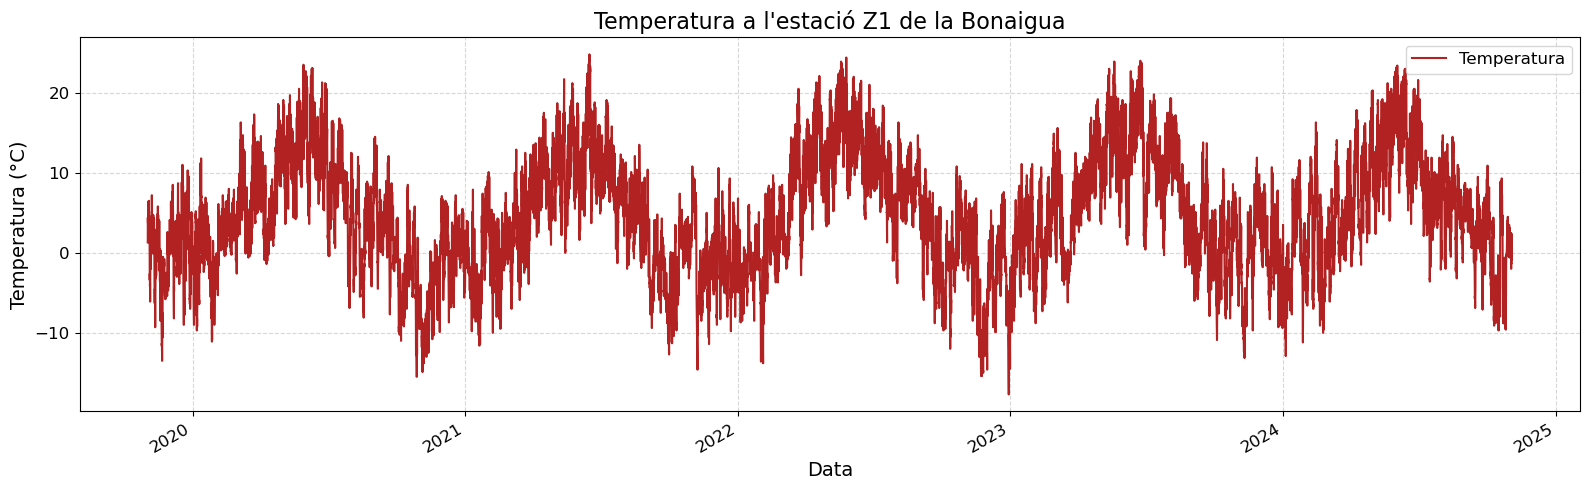

In [13]:
plt.figure(figsize=(16, 5))
plt.plot(df_lstm['data'], df_lstm['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l’eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Prova 1 Pipeline

In [ ]:
# Parametres Globals del model LSTM
 

# Parametres influents del model LSTM (Cal fer proves)

WINDOW_SIZE = 24                # nombre de mostres per a la finestra de temps (24 hores)
N_OUTPUTS = 1                   # Per predicció simple, si fos multi-step seria > 1
N_LAYERS = 3                    # Nombre de capes LSTM
N_UNITS = 64                    # Nombre d'unitats per capa LSTM
DROPOUT_RATE = 0.2              # Taxa de dropout per evitar sobreajust


# Parametres menys influents del model LSTM (no cal tocar-los gaire)

BATCH_SIZE = 128                # Mida del batch per entrenament
EPOCHS = 50                     # Nombre d'èpoques per entrenament
PATIENCE = 5                    # Paciencia per EarlyStopping    
N_SLIDE = N_OUTPUTS             # Desplaçament de la finestra, 1 per predicció simple
N_FEATURES = 1                  # Només una variable: temperatura
PREDICTIONS_MOD = [                 # Tipus de predicció a realitzar
            'pred_batch',
            'pred_iter',
            'pred_reinject'
            ]                            

✅ Escalat completat:


Train dataset shape: (39432, 3)
Validation dataset shape: (2208, 3)
Test dataset shape: (2208, 3)
Entrenant el model LSTM...
Entrenant el model LSTM
Epoch 1/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - loss: 0.0122 - val_loss: 0.0020
Epoch 2/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 3/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.0016 - val_loss: 5.6378e-04
Epoch 4/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 0.0012 - val_loss: 6.0061e-04
Epoch 5/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - loss: 9.2069e-04 - val_loss: 6.2868e-04
Epoch 6/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 8.3270e-04 - val_loss: 4.8466e-04
Epoch 7/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - loss: 7.7193e-04 - val_loss: 7.7517e-04
Epoch 8/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 7.4014e-04 - val_loss: 5.0878e-04
Epoch 9/50
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 6.87

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,029 (972.77 KB)

 Trainable params: 83,009 (324.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 166,020 (648.52 KB)

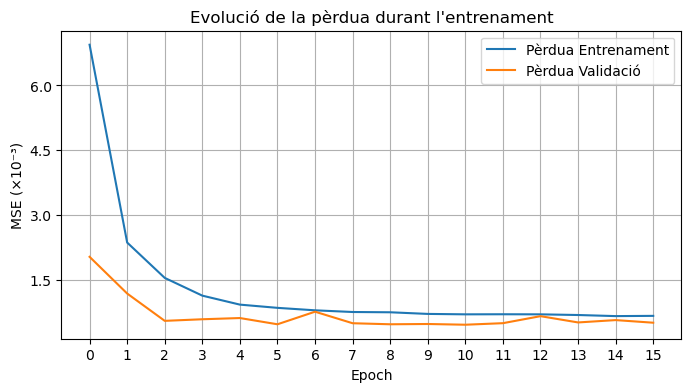

Entrenament completat.


In [6]:
# Definir i entrenar model 

model , scaler, X_train, y_train, X_val, y_val, X_test, y_test, df_train, df_val, df_test, history =  deftrain_model_lstm (

    df_lstm,
    window_size=WINDOW_SIZE, 
    n_outputs=N_OUTPUTS, 
    n_layers=N_LAYERS,
    n_units=N_UNITS,
    dropout_rate=DROPOUT_RATE,
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    patience=PATIENCE
    
)

In [ ]:
df_test_pred , metriques = prediu_model_lstm(
    model,
    X_test,
    df_test,
    scaler,
    window_size=WINDOW_SIZE,
    n_outputs=N_OUTPUTS,
    met_pred=PREDICTIONS_MOD)


In [34]:
display(metriques)
display(df_test_pred)

,pred_batch,pred_iter,pred_reinject
Mètrica,,,
RMSE,0.78,10.51,1.73
MSE,0.61,110.36,3.00
MAE,0.53,9.38,1.22


,data,valor,valor_scaled,pred_batch,pred_iter,pred_reinject
0,2024-10-01 00:00:00+00:00,8.60,0.62,NaN,NaN,NaN
1,2024-10-01 01:00:00+00:00,9.70,0.64,NaN,NaN,NaN
2,2024-10-01 02:00:00+00:00,10.20,0.66,NaN,NaN,NaN
3,2024-10-01 03:00:00+00:00,10.50,0.66,NaN,NaN,NaN
4,2024-10-01 04:00:00+00:00,10.40,0.66,NaN,NaN,NaN
...,...,...,...,...,...,...
2203,2024-12-31 19:00:00+00:00,0.10,0.42,-0.97,-7.71,0.75
2204,2024-12-31 20:00:00+00:00,-0.60,0.40,-0.25,-7.71,-0.25
2205,2024-12-31 21:00:00+00:00,-0.60,0.40,-0.94,-7.71,-0.54
2206,2024-12-31 22:00:00+00:00,-0.70,0.40,-0.94,-7.71,-0.87


In [1]:
fig = plot_prediccions(
    df_train,
    df_val,
    df_test_pred,
    columnes_prediccio=['pred_batch','pred_reinject'])

NameError: name 'plot_prediccions' is not defined

| NOM                                | WINDOW_SIZE | N_OUTPUTS | N_LAYERS | N_UNITS | DROPOUT_RATE | BATCH_SIZE |
|------------------------------------|-------------|-----------|----------|---------|---------------|------------|
| exp_001_ws24_out1_lay1_units1_do0  | 24          | 1         | 1        | 1       | 0.0           | 32         |
| exp_013_ws24_out1_lay2_units1_do0  | 24          | 1         | 2        | 1       | 0.0           | 32         |
| exp_025_ws24_out1_lay3_units1_do0  | 24          | 1         | 3        | 1       | 0.0           | 32         |
| exp_037_ws24_out6_lay1_units1_do0  | 24          | 6         | 1        | 1       | 0.0           | 32         |
| exp_049_ws24_out6_lay2_units1_do0  | 24          | 6         | 2        | 1       | 0.0           | 32         |
| exp_061_ws24_out6_lay3_units1_do0  | 24          | 6         | 3        | 1       | 0.0           | 32         |
| exp_073_ws24_out12_lay1_units1_do0 | 24          | 12        | 1        | 1       | 0.0           | 32         |
| exp_085_ws24_out12_lay2_units1_do0 | 24          | 12        | 2        | 1       | 0.0           | 32         |
| exp_097_ws24_out12_lay3_units1_do0 | 24          | 12        | 3        | 1       | 0.0           | 32         |
| exp_109_ws48_out1_lay1_units1_do0  | 48          | 1         | 1        | 1       | 0.0           | 32         |
| exp_121_ws48_out1_lay2_units1_do0  | 48          | 1         | 2        | 1       | 0.0           | 32         |
| exp_133_ws48_out1_lay3_units1_do0  | 48          | 1         | 3        | 1       | 0.0           | 32         |
| exp_145_ws48_out6_lay1_units1_do0  | 48          | 6         | 1        | 1       | 0.0           | 32         |
| exp_157_ws48_out6_lay2_units1_do0  | 48          | 6         | 2        | 1       | 0.0           | 32         |
| exp_169_ws48_out6_lay3_units1_do0  | 48          | 6         | 3        | 1       | 0.0           | 32         |
| exp_181_ws48_out12_lay1_units1_do0 | 48          | 12        | 1        | 1       | 0.0           | 32         |
| exp_193_ws48_out12_lay2_units1_do0 | 48          | 12        | 2        | 1       | 0.0           | 32         |
| exp_205_ws48_out12_lay3_units1_do0 | 48          | 12        | 3        | 1       | 0.0           | 32         |
| exp_217_ws72_out1_lay1_units1_do0  | 72          | 1         | 1        | 1       | 0.0           | 32         |
| exp_229_ws72_out1_lay2_units1_do0  | 72          | 1         | 2        | 1       | 0.0           | 32         |
| exp_241_ws72_out1_lay3_units1_do0  | 72          | 1         | 3        | 1       | 0.0           | 32         |
| exp_253_ws72_out6_lay1_units1_do0  | 72          | 6         | 1        | 1       | 0.0           | 32         |
| exp_265_ws72_out6_lay2_units1_do0  | 72          | 6         | 2        | 1       | 0.0           | 32         |
| exp_277_ws72_out6_lay3_units1_do0  | 72          | 6         | 3        | 1       | 0.0           | 32         |
| exp_289_ws72_out12_lay1_units1_do0 | 72          | 12        | 1        | 1       | 0.0           | 32         |
| exp_301_ws72_out12_lay2_units1_do0 | 72          | 12        | 2        | 1       | 0.0           | 32         |
| exp_313_ws72_out12_lay3_units1_do0 | 72          | 12        | 3        | 1       | 0.0           | 32         |
| exp_325_ws96_out1_lay1_units1_do0  | 96          | 1         | 1        | 1       | 0.0           | 32         |
| exp_337_ws96_out1_lay2_units1_do0  | 96          | 1         | 2        | 1       | 0.0           | 32         |
| exp_349_ws96_out1_lay3_units1_do0  | 96          | 1         | 3        | 1       | 0.0           | 32         |
